In [1]:
#MCIT Tracking workbook. 
import os
import glob
import argparse
import pyart
import xarray as xr
import numpy as np

from mcit.tracking import overlap_tracking_basic



## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [2]:
#Identify the two files to use in the tracking algorithm
file1 = "/localdata/john.krause/MCIT/KFDR20200522/python_mcit/MCITobj_20200522_235942.nc"
file2 = "/localdata/john.krause/MCIT/KFDR20200522/python_mcit/MCITobj_20200523_000547.nc"


In [3]:
mcit_data1 = xr.open_dataset(file1)
mcit_data2 = xr.open_dataset(file2)



In [4]:
obj1 = mcit_data1["MCIT"]
data1 = mcit_data1["VIL"]
obj2 = mcit_data2["MCIT"]
data2 = mcit_data2["VIL"]

In [5]:
##
#plot them
import pyart
import matplotlib.pyplot as plt
from klaus_krause_cmap import get_obj_cmap

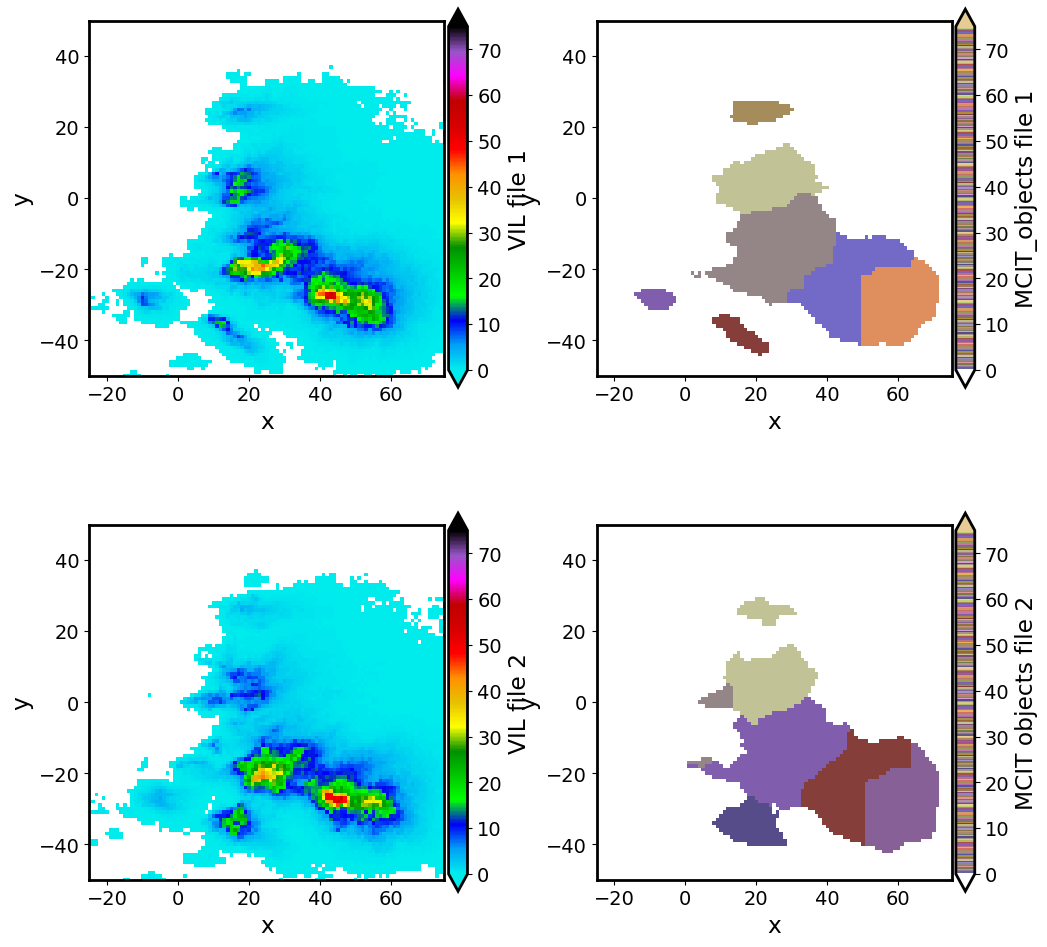

In [6]:
plt.rcParams.update(plt.rcParamsDefault)
#plt.style.use('dark_background')

plt.rcParams.update(
        {'font.size': 14.0,
         'axes.titlesize': 'x-large',
         'axes.linewidth': 2.0,
         'axes.labelsize': 'large'}
    )

axislabels = ["X (km)", "Y (km)"]
axisXlabels = ["X (km)", ""]
axisYlabels = ["", "Y (km)"]
axisnonelabels = ["", ""]
xlim = [-25, 75]
ylim = [-50, 50]
xdiff = xlim[1] - xlim[0]
axps = xdiff * 0.075
ayps = xdiff * 0.025

fig = plt.figure(figsize=(12, 12))
object_cmap = get_obj_cmap()

ax1 = fig.add_subplot(221)
ax1.set_aspect('equal')
ax1.set_ylabel('')
ax1.set_title("")
data1.plot(ax=ax1, x='x', y='y',
                              vmin=0.0, vmax=75.0,
                              xlim=xlim, ylim=ylim,
                              cmap='pyart_NWSRef',
                              add_colorbar=True,
        cbar_kwargs={'extend':'both', 'pad':0.01, 'label':'VIL file 1', 'shrink':0.9}
                                           )


ax2 = fig.add_subplot(222)
ax2.set_aspect('equal')
ax2.set_ylabel('')
ax2.set_title("")

obj1.plot(ax=ax2, x='x', y='y',
                              vmin=0.0, vmax=75.0,
                              xlim=xlim, ylim=ylim,
                              cmap=object_cmap,
                              add_colorbar=True,
        cbar_kwargs={'extend':'both', 'pad':0.01, 'label':'MCIT_objects file 1', 'shrink':0.9}
         )

ax3 = fig.add_subplot(223)
ax3.set_aspect('equal')
ax3.set_ylabel('')
ax3.set_title("")
data2.plot(ax=ax3, x='x', y='y',
                              vmin=0.0, vmax=75.0,
                              xlim=xlim, ylim=ylim,
                      cmap='pyart_NWSRef',
                              add_colorbar=True,
        cbar_kwargs={'extend':'both', 'pad':0.01, 'label':'VIL file 2', 'shrink':0.9}
                                           )


ax4 = fig.add_subplot(224)
ax4.set_aspect('equal')
ax4.set_ylabel('')
ax4.set_title("")

obj2.plot(ax=ax4, x='x', y='y',
                              vmin=0.0, vmax=75.0,
                              xlim=xlim, ylim=ylim,
                              cmap=object_cmap,
                              add_colorbar=True,
        cbar_kwargs={'extend':'both', 'pad':0.01, 'label':'MCIT objects file 2', 'shrink':0.9}
         )
plt.show()

In [7]:
    #Threshold the data arrays based on valid objects. We only want to compute
    #the cost function based on valid object locations
    thresh_data1 = xr.where(obj1 > 0, data1, np.nan)
    thresh_data2 = xr.where(obj2 > 0, data2, np.nan)

    std1 = thresh_data1.std()
    mean1 = thresh_data1.mean()

    std2 = thresh_data2.std()
    mean2 = thresh_data2.mean()


In [8]:
   print("mean1: %f std1: %f mean2: %f std2: %f \n" % ( mean1, std1, mean2, std2))


mean1: 8.111014 std1: 9.024977 mean2: 7.616975 std2: 8.250897 



In [9]:
from mcit.tracking import compute_shiftscore

In [10]:
max_score =0.0
for x in range(-8,8):
    for y in range(-8,8):
        #copy_data2 = thresh_data2.copy()
        shifted_data = thresh_data2.shift( {'x': x, 'y': y} )
        score = compute_shiftscore(std1, mean1, thresh_data1, std2, mean2, shifted_data)
        if score > max_score:
            x_shift = x
            y_shift = y
            max_score = score

        #print("%d %d %f" %(x,y,score))


In [11]:
print("Final shift: %d %d %f\n" %(x_shift, y_shift, max_score))


Final shift: -2 -1 1359.000000



In [12]:
#
#apply the shift that we found
#
shifted_data2 = thresh_data2.shift( {'x':x_shift, 'y':y_shift} )
shifted_obj2 = obj2.shift( {'x':x_shift, 'y':y_shift} )
xr.where( np.isnan(shifted_obj2), -1, shifted_obj2)

<xarray.DataArray 'MCIT' (y: 600, x: 600)>
array([[-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       ...,
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.]])
Coordinates:
  * x        (x) int64 -300 -299 -298 -297 -296 -295 ... 294 295 296 297 298 299
  * y        (y) int64 -300 -299 -298 -297 -296 -295 ... 294 295 296 297 298 299
    lon      (x) float64 -98.98 -98.98 -98.98 -98.98 ... -98.97 -98.97 -98.97
    lat      (y) float64 34.36 34.36 34.36 34.36 ... 34.36 34.36 34.36 34.36

In [13]:
#
from stormcell.stormcell_helpers import create_stormcell_list
#Now we want to assign the object ids in obj2 to the matching ob1 data
# Create and rank objects from obj1 and obj2
#
obj1_list = create_stormcell_list(obj1, data1)
obj2_list = create_stormcell_list(obj2, data2)


In [14]:
from stormcell.stormcell_helpers import rank_stormcell_list, find_stormcell_index

In [15]:
obj1_ranks = rank_stormcell_list(obj1_list)
obj2_ranks = rank_stormcell_list(obj2_list)

In [16]:
print("obj1")
for key, value in obj1_ranks.items():
    print(f"{key}: {value}")

print("obj2")
for key, value in obj2_ranks.items():
    print(f"{key}: {value}")

obj1
14: 0.4
9: 3.0
17: 4.0
3: 4.6
8: 4.800000000000001
13: 5.8
18: 7.2
10: 10.4
11: 11.0
5: 12.2
12: 14.8
21: 15.4
20: 15.6
obj2
11: 1.2000000000000002
6: 1.4
12: 2.0
2: 5.0
10: 5.6
3: 8.2
8: 8.8
18: 8.8
5: 11.0
7: 11.4
17: 13.6


In [17]:
#
#Now we do the assignment part of the tracking code
# Starting with the highest ranked obj2 we try and find an acceptable obj1.
# if we do we assign the id from obj1 to obj2. 
#   (note that  an obj1 id is only used once)
#
# We look for objects that have a 75% overlap between obj2 and obj1
#    Then we lower this threshold to 50%
#       Then we lower this threshold to 25%
#         Then we give up and assign the obj2 a new ID
#
#Note the obj locations we want are those from the shifted data
#

In [18]:
def computeStormCellOverlap(obj2, obj1):
    count=0
    for loc2 in obj2.locs:
        for loc1 in obj1.locs:
            if loc2 == loc1:
                count +=1
    if count == 0:
        return 0.0
    else:
        return count/len(obj2.locs) * 100.0 #overlap as a percentage

In [19]:
#important!
obj2_list = create_stormcell_list(shifted_obj2, shifted_data2)

overlap_thresholds = [75.0, 50.0, 25.0]
#this is found_dic[obj2_id] = obj1_id
found_dic = {}
for overlap_thresh in overlap_thresholds:
    for id2 in obj2_ranks:
        if not id2 in found_dic:
            for id1 in obj1_ranks:
                if not id1 in found_dic.values():
                    obj2_o = obj2_list[find_stormcell_index(id2, obj2_list)]
                    obj1_o = obj1_list[find_stormcell_index(id1, obj1_list)]
                    overlap = computeStormCellOverlap(obj2_o, obj1_o)
                    if overlap >= overlap_thresh:
                        found_dic[id2] = id1
                        print("obj2: %d obj1: %d overlap: %f " % (id2, id1, overlap))
#
#identify the new storm IDs with a new ID
#
rotate_id_value = 1000
#FIXME
max_value_id = 100

for id2 in obj2_ranks:
    if not id2 in found_dic:
        found_dic[id2] = max_value_id
        max_value_id += 1
        if max_value_id >= rotate_id_value:
            max_value_id = 1

print("Found: ")
print(found_dic)
            


obj2: 11 obj1: 14 overlap: 93.205945 
obj2: 12 obj1: 17 overlap: 89.389535 
obj2: 2 obj1: 3 overlap: 87.790698 
obj2: 10 obj1: 13 overlap: 86.244541 
obj2: 6 obj1: 9 overlap: 52.649007 
obj2: 3 obj1: 5 overlap: 53.631285 
obj2: 18 obj1: 18 overlap: 68.763103 
obj2: 7 obj1: 10 overlap: 63.470320 
obj2: 8 obj1: 11 overlap: 36.559140 
Found: 
{11: 14, 12: 17, 2: 3, 10: 13, 6: 9, 3: 5, 18: 18, 7: 10, 8: 11, 5: 100, 17: 101}


In [22]:
#
#Do a where replacement on the original obj2 data and return it as the new
#tracked obj data
#
for key, value in found_dic.items():
    obj2 = xr.where(obj2==key, value, obj2)


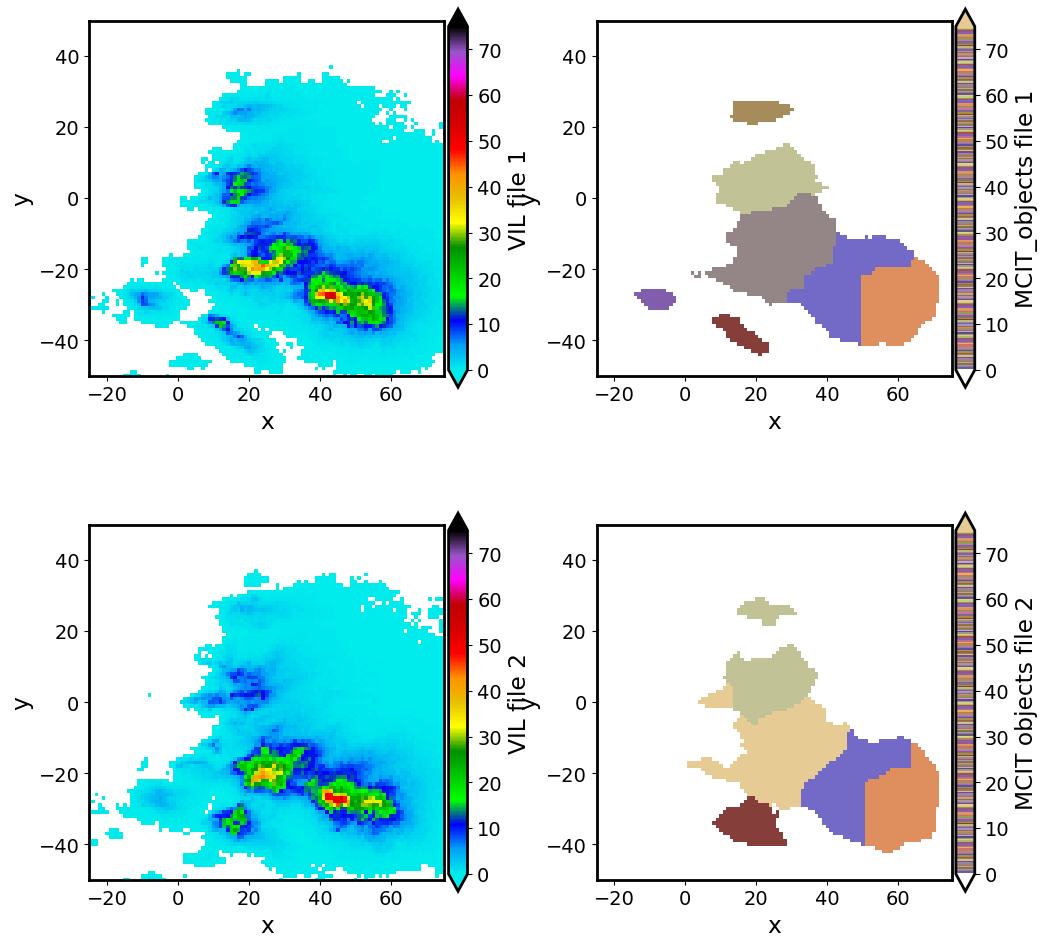

In [23]:
plt.rcParams.update(plt.rcParamsDefault)
#plt.style.use('dark_background')

plt.rcParams.update(
        {'font.size': 14.0,
         'axes.titlesize': 'x-large',
         'axes.linewidth': 2.0,
         'axes.labelsize': 'large'}
    )

axislabels = ["X (km)", "Y (km)"]
axisXlabels = ["X (km)", ""]
axisYlabels = ["", "Y (km)"]
axisnonelabels = ["", ""]
xlim = [-25, 75]
ylim = [-50, 50]
xdiff = xlim[1] - xlim[0]
axps = xdiff * 0.075
ayps = xdiff * 0.025

fig = plt.figure(figsize=(12, 12))
object_cmap = get_obj_cmap()

ax1 = fig.add_subplot(221)
ax1.set_aspect('equal')
ax1.set_ylabel('')
ax1.set_title("")
data1.plot(ax=ax1, x='x', y='y',
                              vmin=0.0, vmax=75.0,
                              xlim=xlim, ylim=ylim,
                              cmap='pyart_NWSRef',
                              add_colorbar=True,
        cbar_kwargs={'extend':'both', 'pad':0.01, 'label':'VIL file 1', 'shrink':0.9}
                                           )


ax2 = fig.add_subplot(222)
ax2.set_aspect('equal')
ax2.set_ylabel('')
ax2.set_title("")

obj1.plot(ax=ax2, x='x', y='y',
                              vmin=0.0, vmax=75.0,
                              xlim=xlim, ylim=ylim,
                              cmap=object_cmap,
                              add_colorbar=True,
        cbar_kwargs={'extend':'both', 'pad':0.01, 'label':'MCIT_objects file 1', 'shrink':0.9}
         )

ax3 = fig.add_subplot(223)
ax3.set_aspect('equal')
ax3.set_ylabel('')
ax3.set_title("")
data2.plot(ax=ax3, x='x', y='y',
                              vmin=0.0, vmax=75.0,
                              xlim=xlim, ylim=ylim,
                      cmap='pyart_NWSRef',
                              add_colorbar=True,
        cbar_kwargs={'extend':'both', 'pad':0.01, 'label':'VIL file 2', 'shrink':0.9}
                                           )


ax4 = fig.add_subplot(224)
ax4.set_aspect('equal')
ax4.set_ylabel('')
ax4.set_title("")

obj2.plot(ax=ax4, x='x', y='y',
                              vmin=0.0, vmax=75.0,
                              xlim=xlim, ylim=ylim,
                              cmap=object_cmap,
                              add_colorbar=True,
        cbar_kwargs={'extend':'both', 'pad':0.01, 'label':'MCIT objects file 2', 'shrink':0.9}
         )
plt.show()